In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Taking a sub section of the data and doing some work on just 'good and bad' comments.  Good being anything with a score of more then 50 and bad being anything with a score of less then -1 

In [30]:
# NEED TO MAKE THIS A FUNCTION. SOMTHING TO QUERY DATA THAT I WANT.

import json
import decimal
import boto3
from boto3.dynamodb.conditions import Key, Attr

dynamodb = boto3.resource('dynamodb')
comment_table = dynamodb.Table('comments')

# Helper class to convert a DynamoDB item to JSON.
class DecimalEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, decimal.Decimal):
            if o % 1 > 0:
                return float(o)
            else:
                return int(o)
        return super(DecimalEncoder, self).default(o)



posts = []
    
response = comment_table.scan(
    FilterExpression=Attr('score').lt(-1) | Attr('score').gt(50)
    )

for i in response['Items']:
    posts.append(json.loads(json.dumps(i, cls=DecimalEncoder)))

while 'LastEvaluatedKey' in response:
    response = comment_table.scan(
        FilterExpression=Attr('score').lt(-1) | Attr('score').gt(50),
        ExclusiveStartKey=response['LastEvaluatedKey']
        )

    for i in response['Items']:
        posts.append(json.loads(json.dumps(i, cls=DecimalEncoder)))

In [2]:
# df = pd.read_pickle('data/comments.pkl')
df = pd.DataFrame(posts)

In [3]:
df.head()

,comment_id,post_user,subreddit,post_date,score,votes_up,awards,comment_parent,comment_depth,votes_down,post_id,gilded,body,is_gilded
0,t1_f507ph6,t2_4ofie5cy,AmItheAsshole,2019-10-24 21:20:22,0,0,[],t3_dmcw3y,0,0,t3_dmcw3y,0,NTA - That's pure comedy right there.,False
1,t1_f43sa8o,t2_4uzl8ko,tifu,2019-10-18 04:37:20,1,1,[],t3_dj95o8,0,0,t3_dj95o8,0,It’s cause it makes you looks Muslim bro,False
2,t1_f4aiyb5,t2_3sqf72hz,AmItheAsshole,2019-10-19 22:39:15,-6,-6,[],t1_f49rjr5,6,0,t3_djvsug,0,"Fair question, but no. If OP has spent time wi...",False
3,t1_evptaf7,t2_8z660,ProRevenge,2019-08-02 01:17:33,3,3,[],t1_evppdql,4,0,t3_ckpob7,0,Maybe Russia.,False
4,t1_f4i41t7,t2_15zkq6,tifu,2019-10-21 03:30:31,1,1,[],t3_dkm5gj,0,0,t3_dkm5gj,0,Well you're acting like the ball is in his cou...,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535223 entries, 0 to 535222
Data columns (total 14 columns):
comment_id        535223 non-null object
post_user         535223 non-null object
subreddit         535223 non-null object
post_date         535223 non-null datetime64[ns]
score             535223 non-null int64
votes_up          535223 non-null int64
awards            535223 non-null object
comment_parent    535223 non-null object
comment_depth     535223 non-null int64
votes_down        535223 non-null int64
post_id           535223 non-null object
gilded            535223 non-null int64
body              535223 non-null object
is_gilded         535223 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(5), object(7)
memory usage: 53.6+ MB


In [6]:
# lets filter down to what I am looking at
df = df.query('score > 50 or score < -1')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57546 entries, 2 to 535219
Data columns (total 14 columns):
comment_id        57546 non-null object
post_user         57546 non-null object
subreddit         57546 non-null object
post_date         57546 non-null datetime64[ns]
score             57546 non-null int64
votes_up          57546 non-null int64
awards            57546 non-null object
comment_parent    57546 non-null object
comment_depth     57546 non-null int64
votes_down        57546 non-null int64
post_id           57546 non-null object
gilded            57546 non-null int64
body              57546 non-null object
is_gilded         57546 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(5), object(7)
memory usage: 6.2+ MB


While that really hurt our dataset I am interested to see what things look like.  

Time to get some info about our data. 

In [68]:
df['word_count'] = df.body.apply(lambda x: len(x.split(' ')))

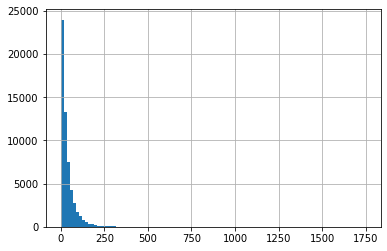

In [69]:
df.word_count.hist(bins=100)

In [49]:
(word_count > 400).sum()

116

In [ ]:
ok lets make this a little better 

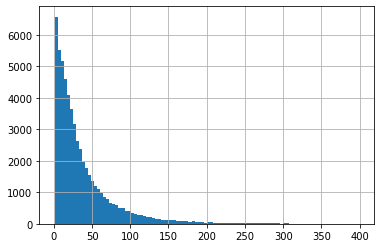

In [70]:
df.word_count[word_count < 400].hist(bins=100)

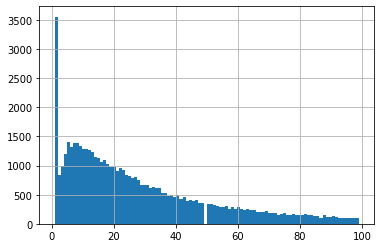

In [71]:
df.word_count[word_count < 100].hist(bins=100)

Looking at this it seems that there are a lot of posts with only a few words.  There seem to be a lot of one word things. This is not necessarly my goal so I need to investigate

In [72]:
df[df.word_count <= 1]['body'].value_counts()

[deleted]                      1543
[removed]                       849
YTA                              70
NTA                              44
ESH                              35
                               ... 
WORLDSTARRRRRRR                   1
r/TooManyFuckingRevengeSubs       1
m'FWILLA                          1
R/idontcare                       1
Downvote.                         1
Name: body, Length: 725, dtype: int64

It looks like I should remove these as I am more interested in what can be written and what I see here is removed comments and links to other things.  Below we can see 2 word outcomes Im just going to include things with 4 or more words.

In [73]:
df[df.word_count == 2]['body'].value_counts()

Holy shit                  12
Thank you!                  6
Thank you                   6
Fair enough                 4
no u                        3
                           ..
Well played                 1
Soviet Union*               1
"Bye, bitch."               1
threesome? ¯\\\_(ツ)\_/¯     1
It's irrelevant             1
Name: body, Length: 775, dtype: int64

In [74]:
filter_df = df[df.word_count >= 4]

In [76]:
filter_df['is_neg'] = filter_df.score < 0

/Users/danielrupp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [77]:
filter_df.is_neg.sum()/df.shape[0]

0.4446182184687033

This is a rather balanced data set.   

Which is nice.  For a first pass on a model I am going to keep all stop words.  I am going to eventlually want to try some lemitizing and a had created stop word list as things like `I` or `am` may be important.

I want to see what things look like given the 2 classes and I am going to limit to under 200 words for several reasons

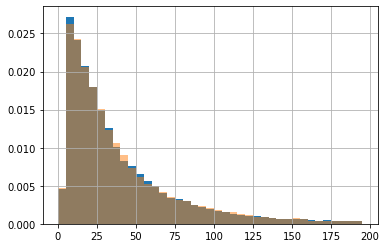

In [85]:
bin_sizes = np.arange(0,200,5)

fig, ax = plt.subplots()

filter_df[(filter_df.is_neg == 0) & (filter_df.word_count < 201)].word_count.hist(
    bins=bin_sizes, density=True, ax=ax)
filter_df[(filter_df.is_neg == 1) & (filter_df.word_count < 201)].word_count.hist(
    bins=bin_sizes, density=True, alpha=.5, ax=ax)




Well they look to be the same so word count does not seem to be useful on telling how people react to a given post. 

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [87]:
y = filter_df.is_neg
X = filter_df.body

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [109]:
tfidf = TfidfVectorizer()
vect_train_X = tfidf.fit_transform(X_train)

In [110]:
vect_train_X.shape

(34951, 30553)

In [111]:
vect_test_X = tfidf.fit_transform(X_train)

In [201]:
stop_words = []
tfidf = TfidfVectorizer(min_df=.001, stop_words='english')
vect_train_X = tfidf.fit_transform(X_train)

In [202]:
vect_train_X.shape

(34951, 2463)

In [203]:
vect_test_X = tfidf.transform(X_test)

In [204]:
rf_model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
rf_model.fit(vect_train_X, y_train)
rf_model.score(vect_test_X, y_test)

0.60432156133829

In [127]:
cv = CountVectorizer(min_df=.01)
cv_X = cv.fit_transform(filter_df.body)

In [128]:
cv_X.shape

(52167, 437)

In [174]:
word_occur = cv_X.todense().sum(axis=0)

In [182]:
voc = cv.vocabulary_

In [185]:
word_vocab = {v:k for k,v in voc.items()}

In [200]:
stop_words = []
for i in [39, 166, 134, 273, 292, 227, 386,  87, 280,  18,   3, 407, 426,
          91,  33,  59, 269,  27, 327, 206, 189,  24, 240, 264, 360, 418,
         162,  38, 176, 398, 157, 159,  53, 316, 365, 253, 434, 121, 179,
         182, 258, 353, 185,  19, 433, 372, 354][::-1]:
    print(word_vocab[i])

the
to
you
and
it
that
of
is
in
for
your
not
this
she
but
he
have
was
if
be
her
with
they
on
my
are
just
like
so
as
or
can
at
don
would
what
about
an
people
do
up
me
re
out
get
his
because


In [199]:

stop_words = ['the','to','you','and','it','that','of','is','in','for','not','this','but']

In [181]:
word_occur.argsort()

matrix([[ 69,  68,  12, 425, 379,   9, 133, 139, 291, 151, 392, 282, 177,
          71, 313,   1, 377, 337,  76, 140,  42, 122, 252, 160, 196,  13,
         314,  81, 342, 318, 241,  47, 352, 326, 299, 156, 364, 262, 402,
         387, 198, 378, 127,  58, 172, 303,  77, 173, 391, 308, 199,   0,
         153, 131,  75, 234, 322,  54, 215, 132, 250, 207, 311,  72, 336,
         114, 321, 188, 231, 143,  96, 130, 408, 331,  51, 178, 229, 284,
          73, 194, 350, 373, 271, 105, 147, 257,   6, 384, 123, 278, 111,
         334, 403,   4, 175, 224,  66,  52, 315, 118, 152, 164,  62, 203,
         261,  93, 197, 371, 149, 424, 297, 332,  44,  57, 135,  97, 184,
          65, 348, 376, 302, 169,  63, 202,  31, 168,   2, 346, 260,  82,
         343, 422, 243, 137, 104, 385, 248, 421, 397, 237, 249, 146,  30,
         110, 210, 324, 101,  70, 414, 180, 320, 390,  10, 112,  83, 208,
          25,  95, 333,  14, 201, 289, 341, 116, 420,  79, 405, 242, 238,
         396, 265, 200,  49, 174, 300,

In [176]:
type(word_occur)

numpy.matrix

In [154]:
a = word_occur[0,:]

In [139]:
word_occur[:,354]

matrix([[71638]], dtype=int64)